## **Гипотеза №2**
### $H_{0}$ : Средняя цена квартир в зданиях 20 века и в зданиях 21 века не отличается
### $H_{1}$ : Средняя цена квартир в зданиях 20 века ниже средней цены квартир в зданиях 21 века
### Уровень статистической значимости = 0.05

## **Импорт библиотек**

In [1]:
import pandas as pd #библиотека для обработки и анализа данных в виде таблиц
import numpy as np #библиотека, добавляющая поддержку больших многомерных массивов и матриц, вместе с большой библиотекой высокоуровневых математических функций для операций с этими массивами

#scikit-learn — это библиотека, предназначенная для машинного обучения
from sklearn.linear_model import LinearRegression #линейная регрессия
from sklearn import preprocessing #предоставляет функции для преобразования данных в более подходящий вид для последующих оценок

import statsmodels.api as sm #позволяет исследовать данные, оценивать статистические модели и выполнять статистические тесты
import scipy.stats as stats
import seaborn as sns #эта библиотека предназначена для создания статистических графиков

from pyhive import hive

## **Подключение к базе данных и импорт данных**

In [2]:
#mart2 = pd.read_csv('mart2.csv')
conn = hive.Connection(host='localhost', port=10000, database='project')
cursor = conn.cursor()
query = "SELECT * FROM mart_3"
mart3 = pd.read_sql(query, conn)

/tmp/ipykernel_41644/710816630.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  mart3 = pd.read_sql(query, conn)


In [3]:
mart3.head()

,mart_3.id,mart_3.price,mart_3.district,mart_3.rooms,mart_3.total_area,mart_3.current_floor,mart_3.max_floor,mart_3.build_year,mart_3.bath,mart_3.repair,mart_3.window_type
0,0,7700000.0,Коммунарка поселок,NaN,NaN,22.0,27.0,2013.0,1 совмещенный,Косметический,Во двор
1,1,6000000.0,Щербинка,1.0,NaN,3.0,5.0,1974.0,1 совмещенный,Косметический,Во двор
2,2,6000000.0,Очаково-Матвеевское,1.0,NaN,6.0,16.0,1976.0,1 раздельный,Косметический,Во двор
3,3,8200000.0,Сосенское поселение,NaN,NaN,10.0,17.0,2022.0,1 совмещенный,Дизайнерский,Во двор
4,4,5450000.0,Ясенево,NaN,21.0,1.0,9.0,1976.0,1 совмещенный,Евроремонт,На улицу и двор


## **Очищение и преобразование данных**

**Выброс** — это наблюдение, которое лежит аномально далеко от других значений в наборе данных. Выбросы могут быть проблематичными, поскольку они могут повлиять на результаты анализа.
Для удаления выбросов будем использовать межквартильный диапазон.

**Межквартильный размах (IQR)** — это разница между 75-м процентилем (Q3) и 25-м процентилем (Q1) в наборе данных. Он измеряет разброс средних 50% значений.
Можно определить наблюдение как выброс, если оно в 1,5 раза превышает межквартильный размах, превышающий третий квартиль (Q3), или в 1,5 раза превышает межквартильный размах, меньше первого квартиля (Q1).
Выбросы = наблюдения > Q3 + 1,5*IQR или Q1 – 1,5*IQR

In [4]:
mart3.dropna(subset=['mart_3.price'], inplace=True)
q3, q1 = np.percentile(mart3['mart_3.price'], [75, 25]) #получаем 75-й и 25-й процентили колонки price
IQR = q3 - q1 #рассчитываем межквартильный размах
upper_bound = q3 + 1.5 * IQR #получаем высшую границу
lower_bound = q1 - 1.5 * IQR #получаем низшую границу

mart3 = mart3[(mart3['mart_3.price'] < upper_bound) & (mart3['mart_3.price'] > lower_bound)] #выбираем только те записи, у которых цена находится в пределах границ

In [5]:
#линейная регрессия не может работать со строками, их нужно заменить на числовые значения
le = preprocessing.LabelEncoder() #(Кодирование меток) - метод, который присваивает каждому уникальному значению категориального признака уникальное целочисленное значение
le.fit(mart3['mart_3.district'])
mart3['district_num'] = le.transform(mart3['mart_3.district']) #создание нового столбца с замененными строковыми данными на целочисленные

Выбираем нужные столбцы и удаляем записи с пропущенными значениями

In [6]:
model_data = mart3.loc[:, ['mart_3.price', 'district_num', 'mart_3.rooms', 'mart_3.current_floor', 'mart_3.build_year']].dropna()

## **Проверка гипотезы о равенстве средних**

<Axes: xlabel='mart_3.price', ylabel='Count'>

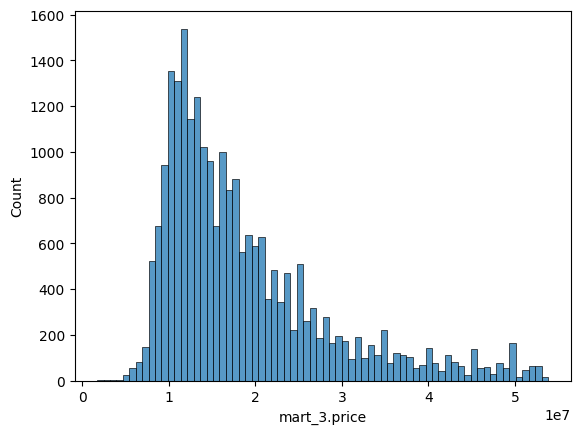

In [7]:
sns.histplot(data=model_data, x="mart_3.price")

In [8]:
stat, p = stats.shapiro(model_data['mart_3.price'])
print('Statistics=%.3f, p-value=%.3f' % (stat, p))

Statistics=0.856, p-value=0.000


/home/dextazzzy/.local/lib/python3.10/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


p-value < уровня статистической значимости (0.05), следовательно данные имеют не нормальное распределение

In [9]:
group1 = model_data[(model_data['mart_3.build_year'] >= 1900) & (model_data['mart_3.build_year'] < 2000)]['mart_3.price']
group2 = model_data[model_data['mart_3.build_year'] >= 2000]['mart_3.price']
stats.mannwhitneyu (group1, group2, alternative='less')

MannwhitneyuResult(statistic=47317377.5, pvalue=0.0)

In [10]:
model_data[(model_data['mart_3.build_year'] >= 1900) & (model_data['mart_3.build_year'] < 2000)]['mart_3.price'].mean()

16445495.01504391

In [11]:
model_data[model_data['mart_3.build_year'] >= 2000]['mart_3.price'].mean()

21464235.994789656

## **Выводы**
p-value < уровня статистической значимости, значит мы опровергаем нулевую гипотезу, следовательно квартиры в зданиях 20 века дешевле квартир в зданиях 21 века